**NI-MVI** - Semestral assignment

This notebook contains code for loading, preprocessing and evaluating the arXiv dataset which consists of many scientific papers. Selected models were trained with goal to predict the papers category labels.

The full info about arXiv and the task can be found here https://www.kaggle.com/Cornell-University/arxiv

The code expects to be run in colab environment, some cells may not work in other editors.

@schejond

First we need to load the dataset into colab. I have used the kaggle api, which gives the fastest access to the dataset.

In [ ]:
!python -m pip install -q kaggle
from google.colab import files
kaggleApiToken = files.upload()

!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
%%time
ARXIV_DATASET_PATH = "/content/arxiv-metadata-oai-snapshot.json"

import os.path
if not os.path.isfile(ARXIV_DATASET_PATH):
  !kaggle datasets download --force --unzip -d Cornell-University/arxiv

 98% 889M/906M [00:22<00:00, 41.7MB/s]
100% 906M/906M [00:22<00:00, 41.8MB/s]
CPU times: user 180 ms, sys: 37.5 ms, total: 217 ms
Wall time: 1min 10s


In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

In [ ]:
# the snapshot can't be loaded directly so we need to obtain it using python generators
def getSnapshotData():
    with open(ARXIV_DATASET_PATH, 'r') as f:
        for line in f:
            yield line

In [ ]:
# first look on data
snapshotData = getSnapshotData()
for paper in snapshotData:
    for key, val in json.loads(paper).items():
        print(key, val)
    break

id 0704.0001
submitter Pavel Nadolsky
authors C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments 37 pages, 15 figures; published version
journal-ref Phys.Rev.D76:013009,2007
doi 10.1103/PhysRevD.76.013009
report-no ANL-HEP-PR-07-12
categories hep-ph
license None
abstract   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and

#### We can see that paper contain numerous information, but I think that only few of them are relevant and important for determining the paper category/ies
* I have decided to experiment with **_id, title, categories, abstract and authors_parsed_** columns and their different combinations

In [ ]:
def getRelevantAttributesForRow(relevantColumns, paper):
  rowData = {}
  for colName in relevantColumns:
    if colName not in paper.keys():
      raise ValueError('Unexpected values! Line keys are not unique! Duplicate key found: ' + colName)
    rowData[colName] = paper[colName]
    
  return rowData

In [ ]:
# experimented with different sets of columns
SELECTED_COLUMNS = ['id', 'title', 'categories', 'abstract', 'authors_parsed']

In [ ]:
%%time
# load selected columns into DataFrame
df = pd.DataFrame(columns = SELECTED_COLUMNS)
for paper in getSnapshotData():
    paper_json = json.loads(paper)
    rowData = getRelevantAttributesForRow(SELECTED_COLUMNS, paper_json)

    df = df.append(
        rowData,
        ignore_index = True
    )
    # for faster loading when i want to write and test code...remove for final experiments
    if len(df) > 50000:
        break

CPU times: user 3min 13s, sys: 1.14 s, total: 3min 14s
Wall time: 3min 14s


In [ ]:
df.head()

,id,title,categories,abstract,authors_parsed
0,0704.0001,Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[[Pan, Hongjun, ]]"
3,0704.0004,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[[Callan, David, ]]"
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [ ]:
df_orig = df.copy()

In [ ]:
df.info()
# display(df.title.head())
display(df.categories.head())
# display(df.abstract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              50001 non-null  object
 1   title           50001 non-null  object
 2   categories      50001 non-null  object
 3   abstract        50001 non-null  object
 4   authors_parsed  50001 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


0             hep-ph
1      math.CO cs.CG
2     physics.gen-ph
3            math.CO
4    math.CA math.FA
Name: categories, dtype: object

In [ ]:
# collect all categories
allCategories = []
for index, row in df.iterrows():
    if ' ' in row.categories:
        for category in row.categories.split(' '):
            allCategories.append(category)
    else:
        allCategories.append(row.categories)

In [ ]:
unique, counts = np.unique(allCategories, return_counts=True)

In [ ]:
frequencies = np.asarray((unique, counts)).T
sortedCategoryCounts = sorted(frequencies, key=lambda x: int(x[1]))

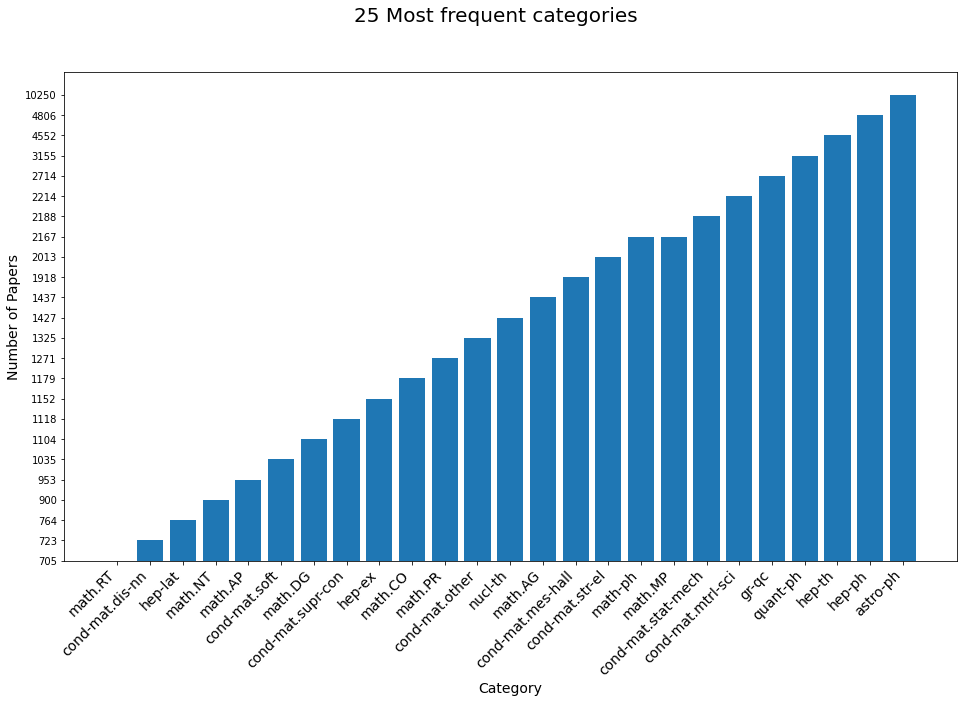

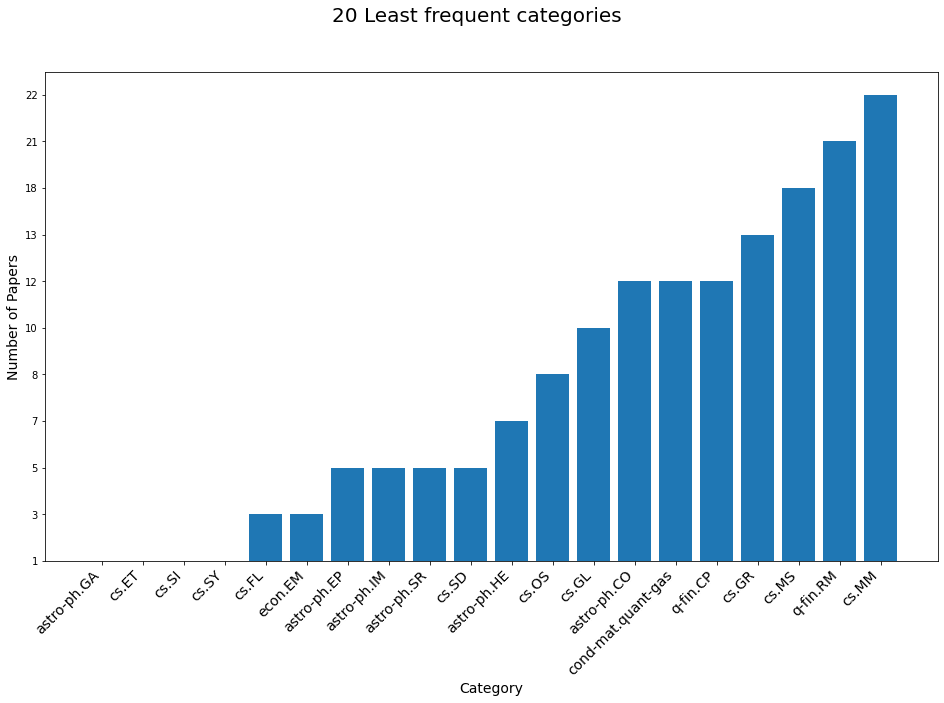

In [ ]:
labels = [x[0] for x in sortedCategoryCounts]
counts = [x[1] for x in sortedCategoryCounts]

fig = plt.figure(figsize=(16, 9))
ax = fig.gca()
fig.suptitle('25 Most frequent categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[-25:], counts[-25:])
plt.show()

fig = plt.figure(figsize=(16, 9))
ax = fig.gca()
fig.suptitle('20 Least frequent categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[:20], counts[:20])
plt.show()

## Data preprocessing
* While discovering the data I have noticed that some papers has been withdrawned. So as my first step I have decided to remove those records.

In [ ]:
df = df[df['abstract'].str.contains('paper has been withdrawn') == False]

1) Get rid of newlines in the **_abstract_** column

In [ ]:
df['abstract'] = df['abstract'].apply(lambda abstract: abstract.replace("\n",""))

2) Based on the stats shown above and also the text classification assignment from kaggle I have decided to edit some of the categories so most of them have more general labels -> the point is to make predicted categories more general to improve the prediction quality.

For example from cs.OS I create just cs, which stands for computer science generally.

In [ ]:
def cropCategories(categories):
    if ' ' in str(categories):
        result = []
        for category in str(categories).split(' '):
            result.append(category.split('.')[0])
        return result
    
    return [str(categories).split('.')[0]]

In [ ]:
df['categories'] = df.categories.apply(cropCategories)

The unique categories should be updated after changes above

In [ ]:
allCategories = []
for index, row in df.iterrows():
    for category in row.categories:
      allCategories.append(category)
uniqueCategories = np.unique(allCategories)

Some rows may contain duplicates of the same categories now (like [math, math])

In [ ]:
def removeDuplicates(categoryList):
  myset = set(categoryList)
  return list(myset)

In [ ]:
df['categories'] = df.categories.apply(removeDuplicates)

3) Strip **__abstract__** and **__title__** of too long white spaces

In [ ]:
df['abstract'] = df['abstract'].apply(lambda x: x.strip())
df['title'] = df['title'].apply(lambda x: x.strip())

4) I have noticed that some of the texts contains special characters (like mathematic symbols) so I decided to create a function which would do some general preprocessing techniques on the texts

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    return sentence

In [ ]:
df['abstract'] = df['abstract'].apply(preprocess_text)
df['title'] = df['title'].apply(preprocess_text)

5) Remove stop words from **__abstract__** column

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def removeStopWords(text):
    textTokens = word_tokenize(text)
    tokensWithoutStopWords = [word for word in textTokens if not word in stopwords.words()]
    textWithoutStopWords = (" ").join(tokensWithoutStopWords)
    return textWithoutStopWords

In [ ]:
%%time
df_stopwords_removed = df.copy()
df_stopwords_removed['abstract'] = df['abstract'].apply(removeStopWords)
df = df_stopwords_removed.copy()

CPU times: user 3h 47min 30s, sys: 25min 49s, total: 4h 13min 19s
Wall time: 4h 13min 25s


Stop-words removal took approx. 1 hour for just 10k records.
In the final test with 50k records the stop-words removal took 4h and 13 minutes

6) Lemmatize
* I have decided to use two techniques for the lemmatization. The more common - Wordnet lemmatization and spacy.

In [ ]:
import sys
# needs admin rights
!{sys.executable} -m spacy download en
spacyEnModulName = 'en_core_web_sm' # if the command above was ran without admin rights use 'en_core_web_sm' otherwise use 'en'
import spacy

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
def spacyLemmatize(text):
    sp = spacy.load(spacyEnModulName, disable=['parser', 'ner'])
    # Parse the sentence using the loaded 'en' model
    doc = sp(text)
    # return lemmatized text
    return " ".join([token.lemma_ for token in doc])

In [ ]:
%%time
df_spacy = df['abstract'].apply(spacyLemmatize)

CPU times: user 1h 10min 44s, sys: 38.6 s, total: 1h 11min 22s
Wall time: 1h 11min 23s


In [ ]:
df_spacy['abstract'].head()

0    a fully differential calculation perturbative ...
1    -PRON- describe new algorithm           ell   ...
2    the evolution Earth Moon system describe dark ...
3    -PRON- show determinant stirle cycle number co...
4    in paper show compute     Lambda      alpha   ...
Name: abstract, dtype: object

Lemmatization with spacy took 1 h and 10 minutes for 10k of records, which is really slow. Let's compare it to the **Wordnet Lemmatizer**

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def get_wordnet_pos_tag(word):
    # maps POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def wordnetLemmatize(sentence):
  return ' '.join([wordnet_lemmatizer.lemmatize(w, get_wordnet_pos_tag(w)) for w in nltk.word_tokenize(sentence)])

In [ ]:
%%time
df_wordnet = df.copy()
df_wordnet['abstract'] = df['abstract'].apply(wordnetLemmatize)

CPU times: user 6min 57s, sys: 18.8 s, total: 7min 16s
Wall time: 7min 16s


In [ ]:
df_wordnet['abstract'].head()

0    A fully differential calculation perturbative ...
1    We describe new algorithm ell pebble game colo...
2    The evolution Earth Moon system described dark...
3    We show determinant Stirling cycle number coun...
4    In paper show compute Lambda alpha norm alpha ...
Name: abstract, dtype: object

In [ ]:
df = df_wordnet.copy()

I was suprised by just how faster the classic wornet lemmatizer is. It took just around 1 minute to proceed 10k of records. I will use it for the rest of the tests and also for the final run.

Code cells below were heplfull for saving computed dataset into .csv and loading it, so the experiments can be redone without having to wait long time.

In [ ]:
# save computed data to drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# df_spacy.to_csv('df_spacy.csv')
# !cp df_spacy.csv "drive/My Drive/"
# df_wordnet.to_csv('df_wordnet.csv')
# !cp df_wordnet.csv "drive/My Drive/"
# df_stopwords_removed.to_csv('df_stopwords_removed.csv')
# !cp df_stopwords_removed.csv "drive/My Drive/"

df_stopwords_removed.to_csv('df_stopwords_removed_50k.csv')
!cp df_stopwords_removed_50k.csv "drive/My Drive/"

In [ ]:
# # loading of saved df from drive
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# # id = '100vLC0ngLdIKFgUiLk4xx42AiEp6qQ_p_'  # file id for wordnet
# # id = '1n3DFVPOm9lVYPoYIRwulNrsqDihDgMhyp'  # file id for stop_words_removed
# id = '1Cw6mc4t598UZgyqpu7qsDh_uFswWdPJ_y'  # file id for stop_words_removed_50k

# downloaded = drive.CreateFile({'id':id})

# # downloaded.GetContentFile('df_wordnet.csv')  # file name
# # downloaded.GetContentFile('df_stopwords_removed.csv')  # file name
# downloaded.GetContentFile('df_stopwords_removed_50k.csv')  # file name

# # df = pd.read_csv('df_wordnet.csv')
# # df = pd.read_csv('df_stopwords_removed.csv')
# df = pd.read_csv('df_stopwords_removed_50k.csv')

# df.drop(columns=['Unnamed: 0'], inplace=True)
# df.head(2)

,id,title,categories,abstract,authors_parsed
0,704.0001,Calculation of prompt diphoton production cros...,['hep-ph'],A fully differential calculation perturbative ...,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,704.0002,Sparsity certifying Graph Decompositions,"['math', 'cs']",We describe new algorithm ell pebble game colo...,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."


In [ ]:
# # after drive load the category data type is invalid and needs to be fixed
# def convertToList(text):
#   x = text.replace("\'", "\"")
#   return json.loads(x)
# df['categories'] = df.categories.apply(convertToList)
# df.head(2)

,id,title,categories,abstract,authors_parsed
0,704.0001,Calculation of prompt diphoton production cros...,[hep-ph],A fully differential calculation perturbative ...,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,704.0002,Sparsity certifying Graph Decompositions,"[math, cs]",We describe new algorithm ell pebble game colo...,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."


In [ ]:
# obtain unique categories after preprocessing
allCategories = []
for index, row in df.iterrows():
    for category in row.categories:
      allCategories.append(category)
uniqueCategories = np.unique(allCategories)
print(uniqueCategories, len(uniqueCategories))

['astro-ph' 'cond-mat' 'cs' 'econ' 'gr-qc' 'hep-ex' 'hep-lat' 'hep-ph'
 'hep-th' 'math' 'math-ph' 'nlin' 'nucl-ex' 'nucl-th' 'physics' 'q-bio'
 'q-fin' 'quant-ph' 'stat'] 19


In [ ]:
# code which lead me to performs preprocessing steps 7) and 8)
unique, counts = np.unique(allCategories, return_counts=True)
frequencies = np.asarray((unique, counts)).T
sortedCategoryCounts = sorted(frequencies, key=lambda x: int(x[1]), reverse=True)
sortedCategoryCounts

[array(['math', '12744'], dtype='<U21'),
 array(['astro-ph', '10262'], dtype='<U21'),
 array(['cond-mat', '9201'], dtype='<U21'),
 array(['hep-ph', '4796'], dtype='<U21'),
 array(['hep-th', '4543'], dtype='<U21'),
 array(['physics', '3996'], dtype='<U21'),
 array(['quant-ph', '3142'], dtype='<U21'),
 array(['gr-qc', '2708'], dtype='<U21'),
 array(['cs', '2677'], dtype='<U21'),
 array(['math-ph', '2158'], dtype='<U21'),
 array(['nucl-th', '1427'], dtype='<U21'),
 array(['hep-ex', '1151'], dtype='<U21'),
 array(['nlin', '978'], dtype='<U21'),
 array(['q-bio', '841'], dtype='<U21'),
 array(['stat', '820'], dtype='<U21'),
 array(['hep-lat', '764'], dtype='<U21'),
 array(['nucl-ex', '649'], dtype='<U21'),
 array(['q-fin', '264'], dtype='<U21'),
 array(['econ', '3'], dtype='<U21')]

7) Some of the categories are represented so rarely, that it's better to cut them out from the dataset to get better results. According to my pilot tests the is ~ 20 categories, so I have decided to keep just the 10 most represented categories (all the 10th to ~20th categories had significantly lower number of assigniture to the papers.

I have decided to remove this category from the multi-labels. If it's the only category for the paper, then I will remove the sample completely.

In [ ]:
categoriesToKeep = []
for categoryToKeep in sortedCategoryCounts[:10]:
  categoriesToKeep.append(categoryToKeep[0])

indexesToDrop = []
for index, row in df.iterrows():
  if len(row['categories']) == 1 and row['categories'][0] not in categoriesToKeep:
    indexesToDrop.append(index)
    continue

  rowCategories = []
  for category in row['categories']:
    if category in categoriesToKeep:
      rowCategories.append(category)
  row['categories'] = rowCategories

In [ ]:
print('Length before:', len(df))
df.drop(indexesToDrop, inplace=True)
print('Length after:', len(df))

Length before: 49876
Length after: 46443


8) We have kept the most common categories but some of them are still much more frequent than the others and this can cause the model to be imbalanced.

I have decided to keep the same number of records (samples) for each remaining category. This number is based on the least occured category.
* This may significantly reduce the dataset, but I believe it can bring better results -> that's why I have used this as my last experiment 

In [ ]:
numberOfRecordsToPreserve = int(sortedCategoryCounts[:10][9][1])
numberOfRecordsToPreserve
df_reduced = pd.DataFrame(columns = df.columns)
df_work = df.copy()

for category in categoriesToKeep:
  df_tmp = pd.DataFrame(columns = df.columns)
  indexesToDropFromWorkDf = []
  for index, row in df_work.iterrows():
    if category in row['categories']:
      df_tmp = df_tmp.append(row)
      if len(row['categories']) is 1:
        indexesToDropFromWorkDf.append(index)

  df_work = df_work.drop(indexesToDropFromWorkDf)
  df_reduced = pd.concat([df_reduced, df_tmp.sample(n = numberOfRecordsToPreserve)])

print(len(df_reduced), len(df), numberOfRecordsToPreserve)

21580 46443 2158


In [ ]:
# update unique categories
allCategories = []
for index, row in df.iterrows():
    for category in row.categories:
      allCategories.append(category)
uniqueCategories = np.unique(allCategories)
print(uniqueCategories, len(uniqueCategories))

['astro-ph' 'cond-mat' 'cs' 'econ' 'gr-qc' 'hep-ex' 'hep-lat' 'hep-ph'
 'hep-th' 'math' 'math-ph' 'nlin' 'nucl-ex' 'nucl-th' 'physics' 'q-bio'
 'q-fin' 'quant-ph' 'stat'] 19


In [ ]:
df_prepared = df.copy()

### For the BERT classification I have decided to use MultiLabelBinarizer to create new feature which could be used on the input for BERT. It's a vector which consists of 0 and 1, which represents relevant categories for each text.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer().fit(df.categories)
print(mlb.classes_)
df["categoriesVector"] = df.categories.apply(lambda x : mlb.transform([x])[0])
df["categoriesVector"].head(2)

['astro-ph' 'cond-mat' 'cs' 'econ' 'gr-qc' 'hep-ex' 'hep-lat' 'hep-ph'
 'hep-th' 'math' 'math-ph' 'nlin' 'nucl-ex' 'nucl-th' 'physics' 'q-bio'
 'q-fin' 'quant-ph' 'stat']


0    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
Name: categoriesVector, dtype: object

In [ ]:
# double check that the one hot encoding returned expected format
print(len(df["categoriesVector"].iloc[0]), len(uniqueCategories))
print(df["categoriesVector"].iloc[1], df["categories"].iloc[1])

19 19
[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] ['math', 'cs']


In [ ]:
df_prepared2 = df.copy()

## Split data into test and train sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=13)

# **Evaluation with selected models**

Both models which were used were from the https://huggingface.co/transformers/pretrained_models.html repository.

Selected model arguments were used across many notebook for label prediction models (one of them is https://www.kaggle.com/balraj98/arxiv-abstract-classification-using-roberta) and I was unable to find different params combination which would bring better results.

I have chosen to measure the label ranking average precision for BERT and RoBERTa models and I have put all the results into a table at the end of this notebook.

In [ ]:
import logging
import torch
!python -m pip install -q tokenizers > /dev/null 2>&1
import tokenizers
!python -m pip install -q transformers > /dev/null 2>&1
import transformers
!python -m pip install -q simpletransformers > /dev/null 2>&1
import simpletransformers

In [ ]:
from simpletransformers.classification import MultiLabelClassificationModel

model_args = {
    "reprocess_input_data": True, # If True, the input data will be reprocessed even if a cached file of the input data exists in the cache_dir.
    "overwrite_output_dir": True, # False	If True, the trained model will be saved to the ouput_dir and will overwrite existing saved models in the same directory.
    "save_model_every_epoch": False, # Model occupies 1.4GB size per epoch
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

## BERT

In [ ]:
%%time
bert = MultiLabelClassificationModel("bert", 
                                      "bert-base-cased", 
                                      num_labels=len(uniqueCategories), 
                                      args=model_args, use_cuda=True)

In [ ]:
%%time
bert.train_model(train_df[["abstract", "categoriesVector", "title", "authors_parsed"]])
result, model_outputs, wrong_predictions = bert.eval_model(test_df[["abstract", "categoriesVector", "title", "authors_parsed"]])
print(result)

## RoBERTa

In [ ]:
roberta = MultiLabelClassificationModel("roberta", 
                                      "roberta-base", 
                                      num_labels=len(uniqueCategories),
                                      args=model_args, use_cuda=True)

In [ ]:
%%time
roberta.train_model(train_df[["abstract", "categoriesVector", "title", "authors_parsed"]])
result, model_outputs, wrong_predictions = roberta.eval_model(test_df[["abstract", "categoriesVector", "title", "authors_parsed"]])
print(result)

In [ ]:
# Measured data
# the values represent the LRAP (= Label Ranking Average Precision)
results = pd.DataFrame(columns=['BERT', 'RoBERTa', 'Note', 'ColumnsUsedForPrediction', 'RecordsCnt'])
results = results.append({'BERT': 0.8876747819208918, 'RoBERTa': 0.895506856315016, 'Note': 'Simple preprocessing', 'ColumnsUsedForPrediction': 'abstract', 'RecordsCnt': 10000}, ignore_index=True)
results = results.append({'BERT': 0.8836356769010607, 'RoBERTa': 0.8778261843340559, 'Note': 'Simple preprocessing', 'ColumnsUsedForPrediction': 'abstract, title, authors_parsed', 'RecordsCnt': 10000}, ignore_index=True)
results = results.append({'BERT': 0.8677993055977559, 'RoBERTa': 0.8592867531355426, 'Note': 'After stop-words removal', 'ColumnsUsedForPrediction': 'abstract, title, authors_parsed', 'RecordsCnt': 10000}, ignore_index=True)
results = results.append({'BERT': 0.7389417892459231, 'RoBERTa': 0.7393891208148253, 'Note': 'After lemmatization', 'ColumnsUsedForPrediction': 'abstract, title, authors_parsed', 'RecordsCnt': 10000}, ignore_index=True)
results = results.append({'BERT': 0.6980714449454573, 'RoBERTa': 0.6888157495603684, 'Note': 'After balancing data', 'ColumnsUsedForPrediction': 'abstract, title, authors_parsed', 'RecordsCnt': 10000}, ignore_index=True)
results = results.append({'BERT': 0.8260626355078205, 'RoBERTa': 0.8233040013209578, 'Note': 'Final', 'ColumnsUsedForPrediction': 'abstract, title, authors_parsed', 'RecordsCnt': 50000}, ignore_index=True)
results

,BERT,RoBERTa,Note,ColumnsUsedForPrediction,RecordsCnt
0,0.887675,0.895507,Simple preprocessing,abstract,10000
1,0.883636,0.877826,Simple preprocessing,"abstract, title, authors_parsed",10000
2,0.867799,0.859287,After stop-words removal,"abstract, title, authors_parsed",10000
3,0.738942,0.739389,After lemmatization,"abstract, title, authors_parsed",10000
4,0.698071,0.688816,After balancing data,"abstract, title, authors_parsed",10000
5,0.826063,0.823304,Final,"abstract, title, authors_parsed",50000
